In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from utils.data_visualizator import plot_confusion_matrixes

from utils import DataAggregator
import pandas as pd

from tqdm import tqdm

from xgboost import XGBClassifier

# Classifiers
Next up, we want to use classifying algorithms to predict the outcome of future matches. To do so, we will need to examine what data we have to make use of the features created in the previous notebook. First we will try to predict the outcome of the matches, we will here use grid search to find the best classifier with the best parameteres.

In [2]:
data_aggregator = DataAggregator()
df = data_aggregator.preprocess_data(data_aggregator.get_data(["E0"]), 
                                     date_column="Date",
                                     home_team_column="HomeTeam",
                                     away_team_column="AwayTeam",
                                     result_column="FTR",
                                     form_window=5)

In [3]:
df.head()

,Date,FTR,B365H,B365D,B365A,Year,Month,Day,DayOfWeek,HomeTeamWinForm,...,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,2002-08-17,0,1.727,3.25,4.333,2002,8,17,5,0.415135,...,False,False,True,False,False,False,False,False,False,False
1,2002-08-17,0,2.250,3.25,2.750,2002,8,17,5,0.356981,...,False,False,False,False,False,False,False,False,False,False
2,2002-08-17,1,1.200,5.00,12.000,2002,8,17,5,0.687770,...,False,False,False,False,False,False,True,False,False,False
3,2002-08-17,-1,2.800,3.25,2.200,2002,8,17,5,0.415556,...,False,False,False,False,False,False,False,False,False,False
4,2002-08-17,1,1.727,3.25,4.333,2002,8,17,5,0.426403,...,False,False,False,False,False,False,False,False,False,False


In [4]:
traget = "FTR"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train_df = df_train.drop(columns=[traget, "Date"])
y_train = df_train[traget].map({1: 2, 0: 1, -1: 0})
X_test_df = df_test.drop(columns=[traget, "Date"])
y_test = df_test[traget].map({1: 2, 0: 1, -1: 0})

print(y_train.value_counts(normalize=True), "\n", y_test.value_counts(normalize=True))

FTR
2    0.460025
0    0.293108
1    0.246867
Name: proportion, dtype: float64 
 FTR
2    0.460526
0    0.323684
1    0.215789
Name: proportion, dtype: float64


In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

In [6]:
model_lbls = [
    'dt' # decision tree
    ,'nb' # gaussian naive bayes
    ,'lp'   # linear perceptron
    ,'svc'  # support vector 
    ,'knn'  # k nearest neighbours
    ,'adb'  # adaboost
    ,'rf'   # random forest
    ,'xgb'  # xgboost
]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state, algorithm="SAMME"),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          },
    'xgb': {'name': 'XGBoost            ',
           'estimator': XGBClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          }
}

In [7]:
best_classifiers = {}
best_scores = {}

for model_lbl in tqdm(model_lbls):
    model = models[model_lbl]
    name = model['name'].strip()
    estimator = model['estimator']
    param_grid = model['param']
    
    grid_search = GridSearchCV(estimator=estimator, 
                               param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=5, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    
    best_classifiers[model_lbl] = best_model
    best_scores[model_lbl] = {
        'Best Params': best_params,
        'CV Accuracy': best_score,
        'Test Accuracy': test_score
    }


100%|██████████| 8/8 [04:33<00:00, 34.16s/it]


In [8]:
result = {}

confusion_matrixes = {}

for model_lbl in model_lbls:
    model = best_classifiers[model_lbl]
    
    y_pred = model.predict(X_test)

    full_df = pd.concat([X_test_df.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Prediction"]).reset_index(drop=True)], axis=1)

    accuracy, won = data_aggregator.calculate_accuracy(full_df, "FTR", "Prediction")

    data_aggregator.save_metrics(f"{model_lbl}-classifier", accuracy, won)

    result[model_lbl] = [accuracy, won]

    confusion_matrixes[model_lbl] = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

In [9]:
pd.DataFrame(result, index=["Accuracy", "Won"])

,dt,nb,lp,svc,knn,adb,rf,xgb
Accuracy,0.597368,0.521053,0.568421,0.615789,0.534211,0.636842,0.631579,0.623684
Won,7906.600000,6634.500000,7359.700000,8029.700000,6513.300000,8231.000000,8200.000000,8148.500000


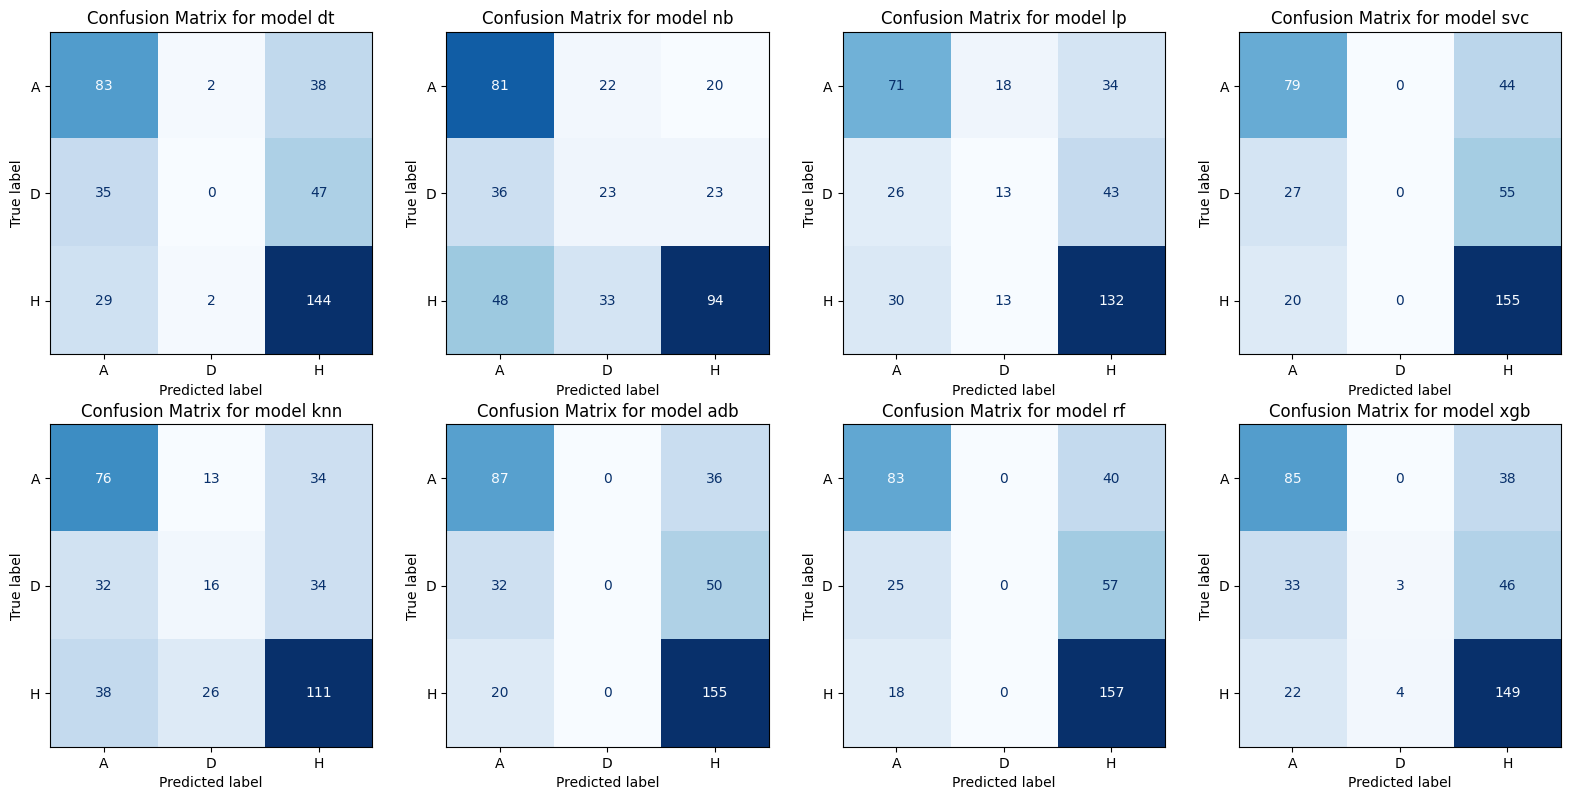

In [10]:
plot_confusion_matrixes(confusion_matrixes, classes=["A", "D", "H"])

As we can see from above, the models really struggles when predicting draws. The accuracy on home- and away wins, however, is pretty decent. Lets then have a look at filtering out those draws, in order to see how the model will perform then.

In [11]:
df = df[df["FTR"] != 0]

df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train_df = df_train.drop(columns=[traget, "Date"])
y_train = df_train[traget]
X_test_df = df_test.drop(columns=[traget, "Date"])
y_test = df_test[traget]

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

Instead of performing the full grid search again, we can see that adaboost performed the best earlier. Lets use that to predict these new matches.

In [13]:
model = AdaBoostClassifier(random_state=random_state, algorithm="SAMME").fit(X_train, y_train)

In [14]:
y_pred = model.predict(X_test)

full_df = pd.concat([X_test_df.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Prediction"]).reset_index(drop=True)], axis=1)

accuracy, won = data_aggregator.calculate_accuracy(full_df, "FTR", "Prediction")

In [15]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(full_df):.0f} out of {len(full_df)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 80.20%
The accuracy of the model is 239 out of 298 games.

With this model, the expected return on value would be 8919.90€


As we can see, if we filter out the draws, we are actually able to predict the matches with an 80% accuracy. Turns out predicting draws is a really difficult task... Well, lets have a look at methods to see if we are able to increase this performance.

In [16]:
data_aggregator.save_metrics("adb-classifier (no draws)", accuracy, won)